In [1]:
import os
import gc
import time
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as m
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

# Datasets

In [2]:
# получение путей к файлам
tiff_files = []
csv_files = []
directory = 'C:/Users/Верт-Миллер/Desktop/jupyter/FIRE/train'
for root, dirs, files in os.walk(directory, topdown = False):
   for file in files:
        if os.path.splitext(file)[1] == '.tiff':
            tiff_files.append(os.path.join(root, file))
        if os.path.splitext(file)[1] == '.csv':
            csv_files.append(os.path.join(root, file))    

In [3]:
%%time
# формирование тренировочного датасета
list_of_df = []
for file_tiff in tiff_files:
    with rasterio.open(file_tiff) as src:
        df = pd.DataFrame(src.read(5).reshape(-1, 1))
        df.columns = ['target']
        for i in range(1, 5):
            df[f'band{i}'] = src.read(i).reshape(-1, 1)
        list_of_df.append(df)

CPU times: total: 203 ms
Wall time: 414 ms


In [4]:
for df, file_csv in zip(list_of_df, csv_files):
    df_csv = pd.read_csv(file_csv)
    df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']
    df_csv = df_csv.ffill()
    for i, j in enumerate(df_csv['t_max'].tolist()[-55:]):
        df[f't_max_day{-55 + i}'] = j

In [5]:
for df, file_csv in zip(list_of_df, csv_files):
    df_csv = pd.read_csv(file_csv)
    df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']
    df_csv = df_csv.ffill()
    for i, j in enumerate(df_csv['wind_way'].tolist()[-55:]):
        df[f't_wind_way_day{-55 + i}'] = j

In [6]:
for df, file_csv in zip(list_of_df, csv_files):
    df_csv = pd.read_csv(file_csv)
    df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']
    df_csv = df_csv.ffill()
    for i, j in enumerate(df_csv['wind_speed'].tolist()[-55:]):
        df[f't_win_speed_day{-55 + i}'] = j 

In [7]:
for df, file_csv in zip(list_of_df, csv_files):
    df_csv = pd.read_csv(file_csv)
    df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']
    df_csv = df_csv.ffill()
    for i, j in enumerate(df_csv['pressure'].tolist()[-55:]):
        df[f't_pressure_day{-55 + i}'] = j

In [8]:
for df, file_csv in zip(list_of_df, csv_files):
    df_csv = pd.read_csv(file_csv)
    df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']
    df_csv = df_csv.ffill()
    for i, j in enumerate(df_csv['rains'].tolist()[-55:]):
        df[f't_rains_day{-55 + i}'] = j            

In [9]:
df_train = list_of_df[1]
for df in list_of_df[2:-1]:
    df_train = pd.concat([df_train, df])
df_train.reset_index(drop=True, inplace=True)   

df_valid = list_of_df[0]
df_valid.reset_index(drop=True, inplace=True)  

df_test = list_of_df[-1]
df_test.reset_index(drop=True, inplace=True)   

In [10]:
df_train.shape  

(4300796, 280)

In [11]:
df_valid.shape

(47730, 280)

In [12]:
df_test.shape

(178182, 280)

In [13]:
X_train = df_train.drop(['target'], axis=1)
y_train = df_train['target']

X_valid = df_valid.drop(['target'], axis=1)
y_valid = df_valid['target']

X_test = df_test.drop(['target'], axis=1)
y_test = df_test['target']

# Model

In [14]:
train_pool = Pool(
        X_train, 
        y_train, 
    )
valid_pool = Pool(
        X_valid, 
        y_valid, 
    )

In [15]:
%%time
clf = CatBoostClassifier(random_state=42,
                         task_type='GPU',
                         learning_rate=0.0005,
                         iterations=685,
                         eval_metric='AUC'
                        )
clf.fit(train_pool, eval_set=valid_pool, verbose=300, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6144612	best: 0.6144612 (0)	total: 234ms	remaining: 2m 39s
300:	test: 0.8344511	best: 0.8665951 (210)	total: 14.1s	remaining: 18s
600:	test: 0.8660100	best: 0.8773238 (550)	total: 26.9s	remaining: 3.76s
684:	test: 0.8825835	best: 0.8825835 (684)	total: 30.5s	remaining: 0us
bestTest = 0.8825835288
bestIteration = 684
CPU times: total: 1min 30s
Wall time: 45.7 s


In [16]:
print(f'ROC_AUC {m.roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1]):2.5f}')

ROC_AUC 0.88258


In [17]:
print(f'ROC_AUC {m.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]):2.5f}')

ROC_AUC 0.90559


# Predict

In [18]:
# указать пути к тестовым файлам 
with rasterio.open(tiff_files[-1]) as src:
        test_shape = (src.read(1).shape)
        df = pd.DataFrame(src.read(1).reshape(-1, 1))
        df.columns = ['band1']
        for i in range(2, 5):
            df[f'band{i}'] = src.read(i).reshape(-1, 1)
        df_csv = pd.read_csv(csv_files[-1])
        df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']
        df_csv = df_csv.ffill()
        for i, j in enumerate(df_csv['t_max'].tolist()[-55:]):
            df[f't_max_day{-55 + i}'] = j 
        for i, j in enumerate(df_csv['wind_way'].tolist()[-55:]):
            df[f't_wind_way_day{-55 + i}'] = j
        for i, j in enumerate(df_csv['wind_speed'].tolist()[-55:]):
            df[f't_win_speed_day{-55 + i}'] = j  
        for i, j in enumerate(df_csv['pressure'].tolist()[-55:]):
            df[f't_pressure_day{-55 + i}'] = j   
        for i, j in enumerate(df_csv['rains'].tolist()[-55:]):
            df[f't_rains_day{-55 + i}'] = j         
        
df

,band1,band2,band3,band4,t_max_day-55,t_max_day-54,t_max_day-53,t_max_day-52,t_max_day-51,t_max_day-50,...,t_rains_day-10,t_rains_day-9,t_rains_day-8,t_rains_day-7,t_rains_day-6,t_rains_day-5,t_rains_day-4,t_rains_day-3,t_rains_day-2,t_rains_day-1
0,11.0,17.0,24.0,49.0,-17.1,-10.2,-18.9,-20.8,-19.1,-12.1,...,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,17.0,25.0,51.0,-17.1,-10.2,-18.9,-20.8,-19.1,-12.1,...,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
2,12.0,16.0,26.0,52.0,-17.1,-10.2,-18.9,-20.8,-19.1,-12.1,...,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
3,10.0,15.0,24.0,51.0,-17.1,-10.2,-18.9,-20.8,-19.1,-12.1,...,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
4,9.0,15.0,23.0,50.0,-17.1,-10.2,-18.9,-20.8,-19.1,-12.1,...,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178177,6.0,8.0,13.0,22.0,-17.1,-10.2,-18.9,-20.8,-19.1,-12.1,...,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
178178,6.0,8.0,12.0,22.0,-17.1,-10.2,-18.9,-20.8,-19.1,-12.1,...,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
178179,5.0,8.0,13.0,21.0,-17.1,-10.2,-18.9,-20.8,-19.1,-12.1,...,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
178180,5.0,8.0,13.0,22.0,-17.1,-10.2,-18.9,-20.8,-19.1,-12.1,...,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
res = clf.predict_proba(df)[:,1]
res

array([0.27744339, 0.28153899, 0.27642296, ..., 0.39446604, 0.39337059,
       0.39337059])

## Кривая Precision-Recall

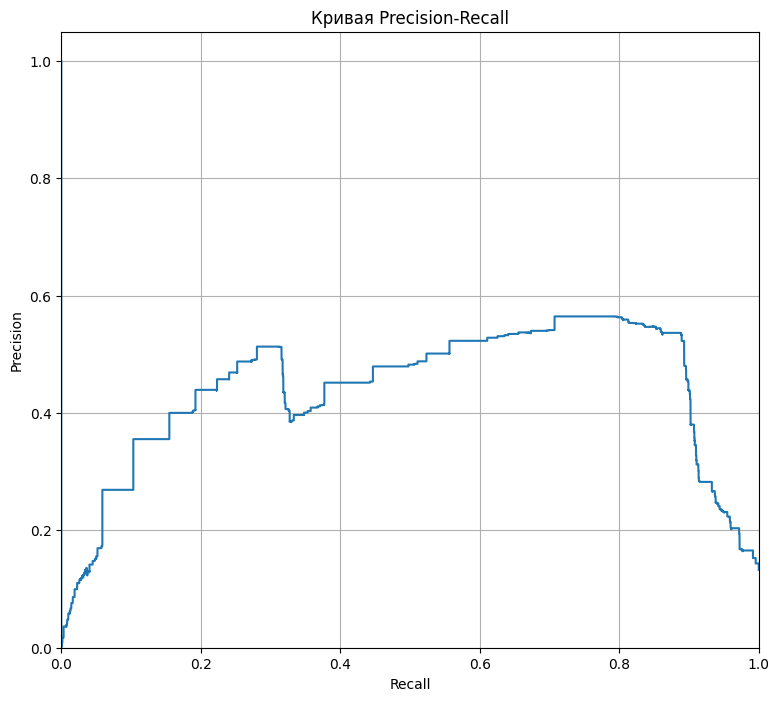

In [20]:
probabilities_valid = clf.predict_proba(X_valid)
precision, recall, thresholds = m.precision_recall_curve(y_valid, probabilities_valid[:, 1])

plt.figure(figsize=(9, 8))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

#  Определяем лучший порог

In [21]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
best_threshold = thresholds[ix]
print(f'Best Threshold= {best_threshold:0.3f}')
best_threshold = thresholds[ix]

Best Threshold= 0.357


## ROC-кривая

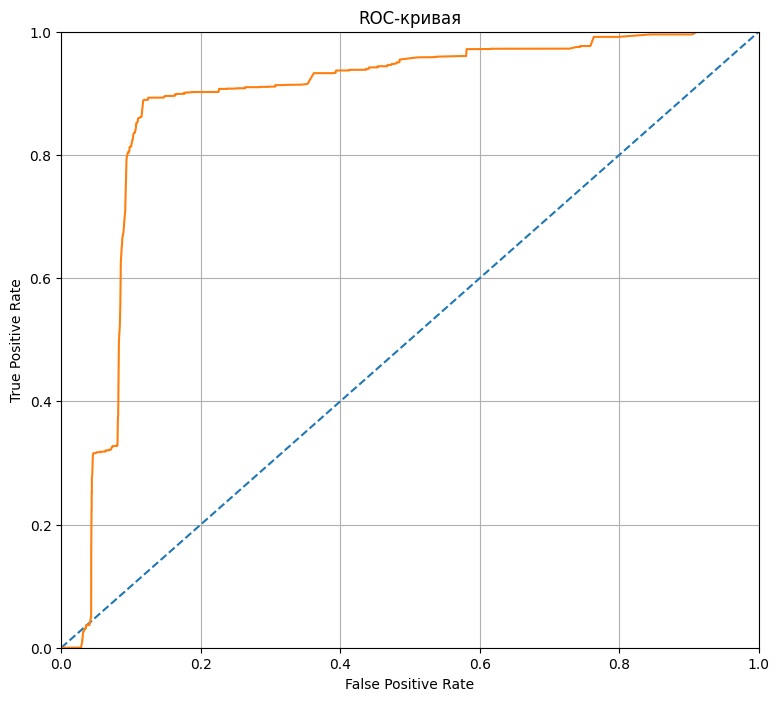

In [22]:
fpr, tpr, thresholds = m.roc_curve(y_valid, probabilities_valid[:, 1])

plt.figure(figsize=(9, 8))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [23]:
res = clf.predict_proba(df)[:,1]
res = np.array([1 if i > best_threshold else 0 for i in res ]).reshape(test_shape) # порог сам придумал, с 0.5 только 6 точек показал :)

In [24]:
res.shape

(342, 521)

In [25]:
# визуализация изображения
def visualize_rgb_geotiff(file_path, r_band, g_band, b_band, ik_band, mask_band, photo_laer: str):
    try:
        with rasterio.open(file_path) as src:
            num_bands = src.count
            print(f"Number of bands: {num_bands}")
            red = src.read(r_band)  # B02 - Blue
            green = src.read(g_band)  # B03 - Green
            blue = src.read(b_band)  # B04 - Red
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            if photo_laer == "full":
                photo = np.stack([red, green, blue], axis=-1)  # Отрисовка всего изображения
            elif photo_laer == "ik_laer":
                photo = np.stack([ik], axis=-1) # Отрисовка ИК-слоя изображения
            elif photo_laer == "mask_laer":
                photo = np.stack([mask], axis=-1)  # Отрисовка маски изображения
            photo = photo.astype(np.uint8)
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(photo)
            ax.axis('off')
            plt.show()
    except Exception as e:
        print(f'Ошибка: {e}')

## Оригинальная маска из 20 изображения

Number of bands: 5


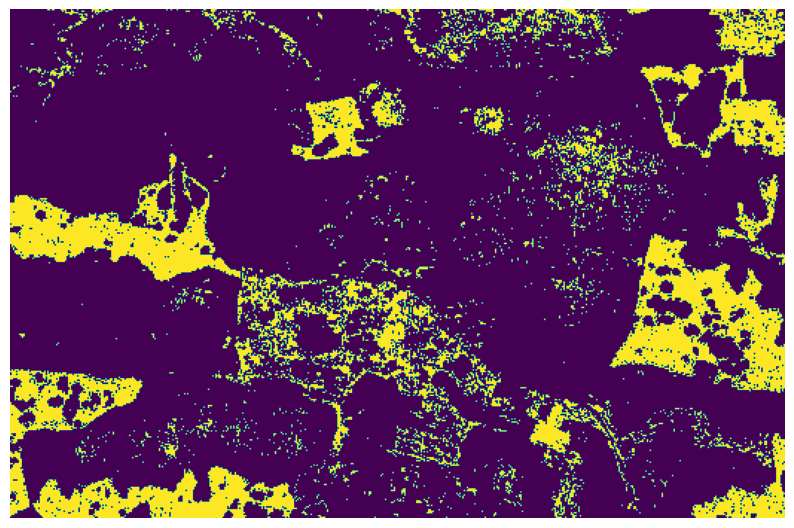

In [26]:
visualize_rgb_geotiff(tiff_files[-1], 1, 2, 3, 4, 5, "mask_laer")

## Предсказанная маска

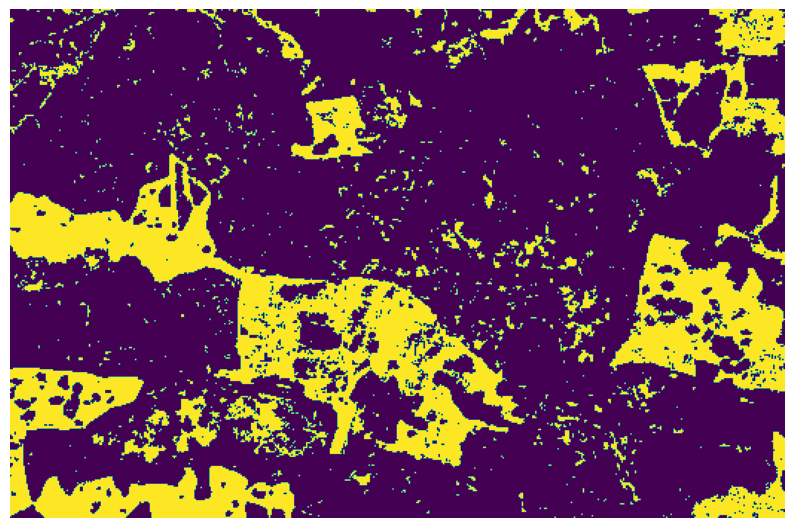

In [27]:
photo = np.stack([res], axis=-1)
photo = photo.astype(np.uint8)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(photo)
ax.axis('off')
plt.show()

# Обучение модели на всех данных для деплоя 

In [28]:
df_train = list_of_df[0]
for df in list_of_df[1:]:
    df_train = pd.concat([df_train, df])
df_train.reset_index(drop=True, inplace=True)

X = df_train.drop(['target'], axis=1)
y = df_train['target']

train_pool = Pool(X, y)

In [29]:
%%time
clf = CatBoostClassifier(random_state=42,
                         task_type='GPU',
                         learning_rate=0.0005,
                         iterations=685,
                        )
clf.fit(train_pool, verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6923328	total: 75ms	remaining: 51.3s
200:	learn: 0.5504540	total: 9.95s	remaining: 24s
400:	learn: 0.4481501	total: 19.6s	remaining: 13.9s
600:	learn: 0.3748823	total: 29.1s	remaining: 4.06s
684:	learn: 0.3507345	total: 32.9s	remaining: 0us
CPU times: total: 1min 28s
Wall time: 44.4 s


## Получение маски для новых файлов tiff (снимок) и csv (погода) на выходе nampy array, который и надо отправлять на ЛБ

### ВНИАНИЕ!!! порог стоит расчитанный (best_threshold = 0.357) им надо играть

In [30]:
# указать пути к тестовым файлам 
with rasterio.open(tiff_files[-1]) as src:
        test_shape = (src.read(1).shape)
        df = pd.DataFrame(src.read(1).reshape(-1, 1))
        df.columns = ['band1']
        for i in range(2, 5):
            df[f'band{i}'] = src.read(i).reshape(-1, 1)
        df_csv = pd.read_csv(csv_files[-1])
        df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']
        df_csv = df_csv.ffill()
        for i, j in enumerate(df_csv['t_max'].tolist()[-55:]):
            df[f't_max_day{-55 + i}'] = j 
        for i, j in enumerate(df_csv['wind_way'].tolist()[-55:]):
            df[f't_wind_way_day{-55 + i}'] = j
        for i, j in enumerate(df_csv['wind_speed'].tolist()[-55:]):
            df[f't_win_speed_day{-55 + i}'] = j  
        for i, j in enumerate(df_csv['pressure'].tolist()[-55:]):
            df[f't_pressure_day{-55 + i}'] = j   
        for i, j in enumerate(df_csv['rains'].tolist()[-55:]):
            df[f't_rains_day{-55 + i}'] = j         

In [31]:
res = clf.predict_proba(df)[:,1]
res = np.array([1 if i > best_threshold else 0 for i in res ]).reshape(test_shape)

In [32]:
res

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])